This notebook explores and analyzes 311 calls regarding homelessness in San Fransisco.

## 1. Open, look at data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('/Users/augusthays/projects/datasets/311_Cases_20250328.csv')

In [3]:
df.head(2)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Police District,Latitude,Longitude,Point,point_geom,Source,Media URL,BOS_2012,data_as_of,data_loaded_at
0,13410381,01/25/2021 10:47:00 AM,01/26/2021 08:22:17 AM,01/26/2021 08:22:17 AM,Closed,Case Resolved - Police Officer responded to re...,Police - Homeless Concerns Queue,Homeless Concerns,Individual Concerns,homeless_other,...,TENDERLOIN,37.784372,-122.410357,"(37.7843717, -122.4103566)",POINT (-122.4103566 37.7843717),Mobile/Open311,NaN,6.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
1,13377934,01/16/2021 09:52:00 PM,02/04/2021 11:06:35 AM,02/04/2021 11:06:35 AM,Closed,Unable to Locate,HSOC Queue,Homeless Concerns,Individual Concerns,hsoc_review,...,SOUTHERN,37.771844,-122.421920,"(37.7718442, -122.42192)",POINT (-122.42192 37.7718442),Mobile/Open311,NaN,6.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29498 entries, 0 to 29497
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CaseID                 29498 non-null  int64  
 1   Opened                 29498 non-null  object 
 2   Closed                 29474 non-null  object 
 3   Updated                29498 non-null  object 
 4   Status                 29498 non-null  object 
 5   Status Notes           29482 non-null  object 
 6   Responsible Agency     29498 non-null  object 
 7   Category               29498 non-null  object 
 8   Request Type           29498 non-null  object 
 9   Request Details        29498 non-null  object 
 10  Address                29498 non-null  object 
 11  Street                 29447 non-null  object 
 12  Supervisor District    29447 non-null  float64
 13  Neighborhood           29262 non-null  object 
 14  Analysis Neighborhood  29264 non-null  object 
 15  Po

## 2. Preprocessing

Looking at `.info()`, it appears there are some null values to remove, and a few columns that may not be relevant for this analysis. `BOS_2012`, some columns showing when data was uploaded or accessed, `Media_URL` (totally empty), and `Street` can probably go. `Neighborhood` is a more granular definition, so I will only keep `Analysis Neighborhood` for this project. I also need to convert some columns to datetime, and check for duplicates. 

In [5]:
df['Status'].value_counts()

Closed    29474
Open         24
Name: Status, dtype: int64

In [6]:
print(df.Opened.min())
print(df.Opened.max())

01/01/2016 03:08:09 PM
12/31/2023 03:14:00 PM


In [7]:
relevant_df = df.drop(['Street', 'Neighborhood', 'Media URL', 'BOS_2012', 'data_as_of', 'data_loaded_at'], axis=1)

In [8]:
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29498 entries, 0 to 29497
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CaseID                 29498 non-null  int64  
 1   Opened                 29498 non-null  object 
 2   Closed                 29474 non-null  object 
 3   Updated                29498 non-null  object 
 4   Status                 29498 non-null  object 
 5   Status Notes           29482 non-null  object 
 6   Responsible Agency     29498 non-null  object 
 7   Category               29498 non-null  object 
 8   Request Type           29498 non-null  object 
 9   Request Details        29498 non-null  object 
 10  Address                29498 non-null  object 
 11  Supervisor District    29447 non-null  float64
 12  Analysis Neighborhood  29264 non-null  object 
 13  Police District        29251 non-null  object 
 14  Latitude               29498 non-null  float64
 15  Lo

After deciding which columns to keep, there are stil null values to address.

In [9]:
# Only remove null values from these cols
relevant_df = relevant_df.dropna().drop_duplicates()

In [10]:
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29054 entries, 0 to 29497
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CaseID                 29054 non-null  int64  
 1   Opened                 29054 non-null  object 
 2   Closed                 29054 non-null  object 
 3   Updated                29054 non-null  object 
 4   Status                 29054 non-null  object 
 5   Status Notes           29054 non-null  object 
 6   Responsible Agency     29054 non-null  object 
 7   Category               29054 non-null  object 
 8   Request Type           29054 non-null  object 
 9   Request Details        29054 non-null  object 
 10  Address                29054 non-null  object 
 11  Supervisor District    29054 non-null  float64
 12  Analysis Neighborhood  29054 non-null  object 
 13  Police District        29054 non-null  object 
 14  Latitude               29054 non-null  float64
 15  Lo

In [13]:
relevant_df[['Opened','Closed']] = relevant_df[['Opened', 'Closed']].apply(pd.to_datetime)

In [14]:
relevant_df['Time To Close'] = (relevant_df['Closed'] - relevant_df['Opened']).dt.floor('h')

I also converted time columns to the proper datatype, and created a time to close column, rounded to the nearest hour.

In [15]:
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29054 entries, 0 to 29497
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   CaseID                 29054 non-null  int64          
 1   Opened                 29054 non-null  datetime64[ns] 
 2   Closed                 29054 non-null  datetime64[ns] 
 3   Updated                29054 non-null  object         
 4   Status                 29054 non-null  object         
 5   Status Notes           29054 non-null  object         
 6   Responsible Agency     29054 non-null  object         
 7   Category               29054 non-null  object         
 8   Request Type           29054 non-null  object         
 9   Request Details        29054 non-null  object         
 10  Address                29054 non-null  object         
 11  Supervisor District    29054 non-null  float64        
 12  Analysis Neighborhood  29054 non-null  object 

## 3. EDA

### Look at types of requests by Neighborhood

In [20]:
# These neighborhoods are outliers and affect the scaling, so I will remove them
relevant_df = relevant_df.loc[~relevant_df['Analysis Neighborhood'].isin(
                ['Treasure Island', 'McLaren Park', 'Seacliff'])]

In [21]:
print(df['Request Details'].value_counts())

aggressive_behavior    12973
wellbeing_check         9966
homeless_other          6501
hsoc_review               58
Name: Request Details, dtype: int64


In [22]:
# Split off HSOC review requests, since there are so few of them
grouped = relevant_df[(relevant_df['Request Details'] != 'hsoc_review')].groupby(
    ['Analysis Neighborhood', 'Request Details']
    )['CaseID'].count()

/var/folders/hr/vzsfy545797dmcs1h5cw84pc0000gn/T/ipykernel_91800/2079210938.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(normalized_grouped.index, rotation=45, ha='right')


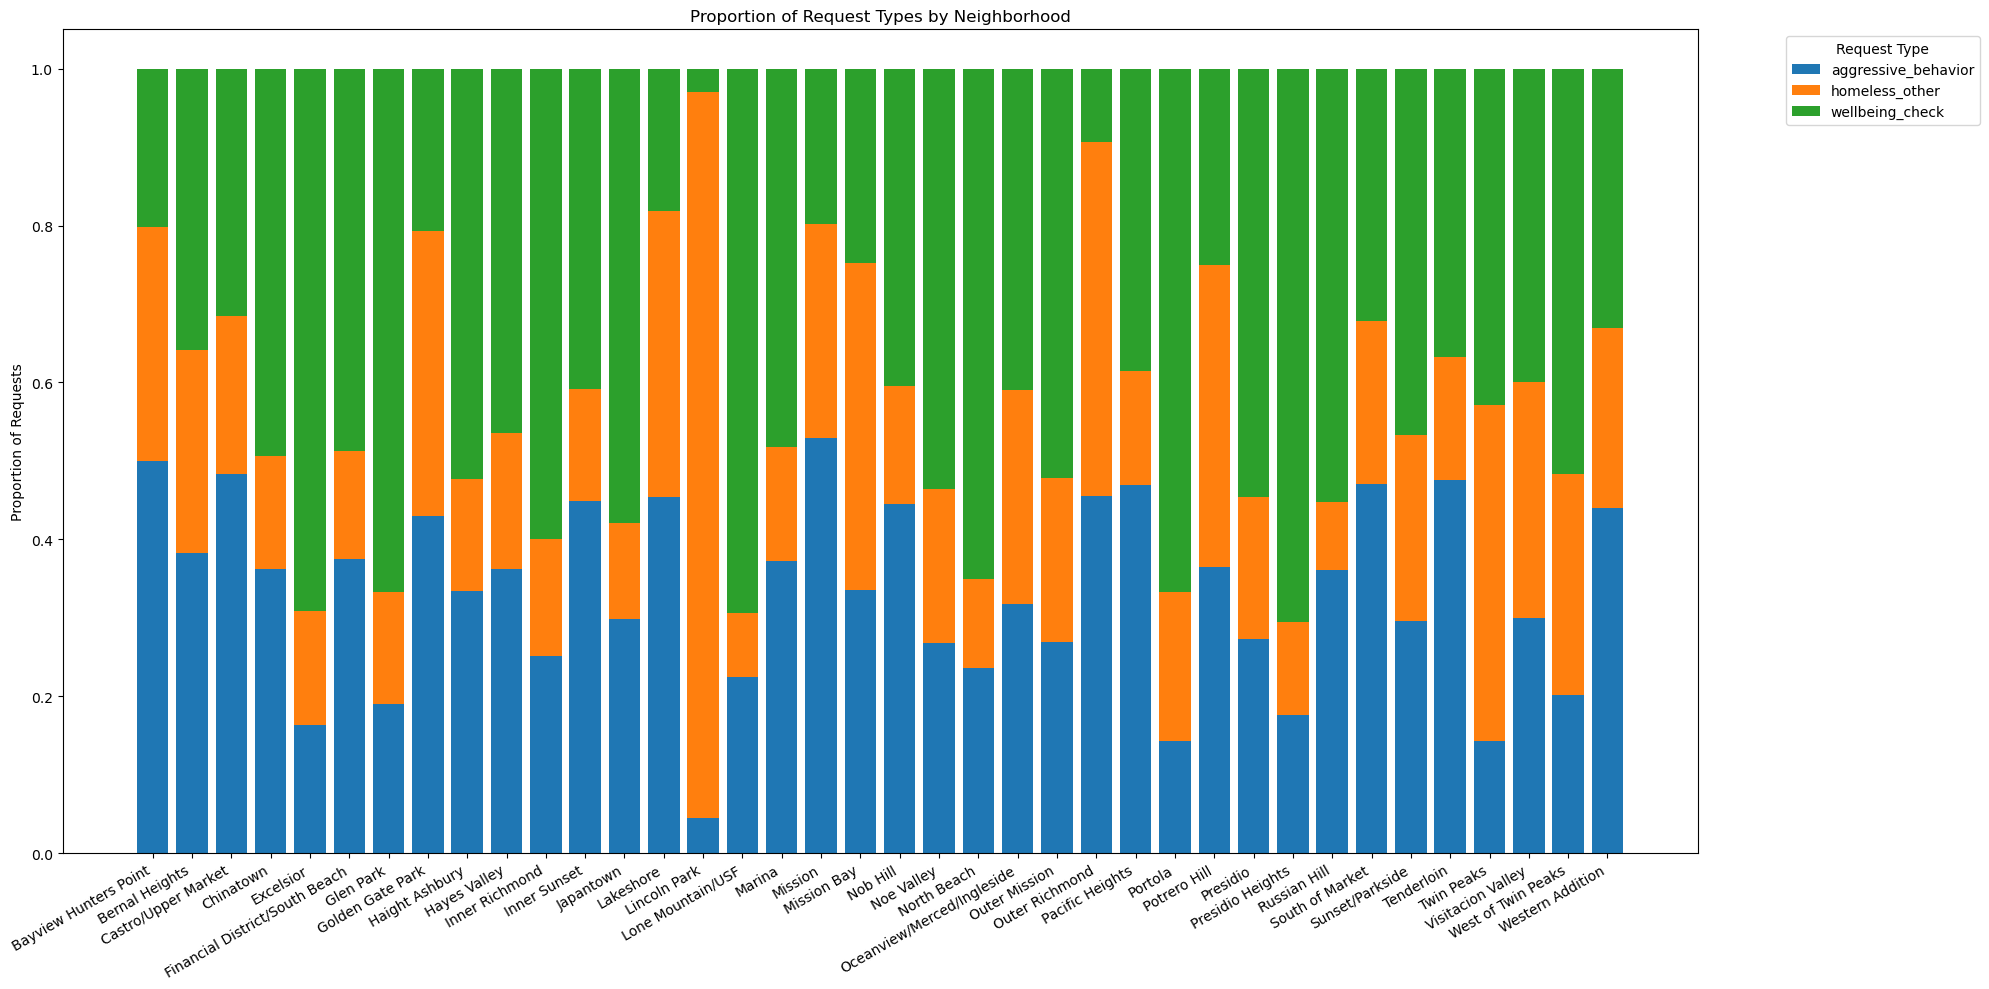

In [23]:
grouped = pd.Series(grouped).unstack(fill_value=0)  # Pivot to get neighborhoods as rows

normalized_grouped = grouped.div(grouped.sum(axis=1), axis=0)  # Each row sums to 1 (100%)

fig, ax = plt.subplots(figsize=(20, 10))

# Define bottom position for stacking bars
bottom = np.zeros(len(normalized_grouped))

for category in normalized_grouped.columns:
    ax.bar(normalized_grouped.index, normalized_grouped[category], label=category, bottom=bottom)
    bottom += normalized_grouped[category]  # Stack the bars

ax.set_xticklabels(normalized_grouped.index, rotation=45, ha='right')
plt.gcf().autofmt_xdate()


ax.set_ylabel("Proportion of Requests")
ax.set_title("Proportion of Request Types by Neighborhood")
ax.legend(title="Request Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Neighborhoods with more requests regarding aggressive behavior include Bayview Hunters Point, Castro/Upper Market, and Mission. Neighborhoods with more well-being checks include Excelsior, Glen Park, Lone Mountain/USF, North Beach, Portola, and Presidio Heights. Interestingly, Lincoln Park had a disproportionately large number of unspecified reports. 

### 311 reports by district vs estimated unhoused population in 2022

I will now look at reports made in each Supervisor District in 2022, compared to an estimate of the unhoused population in that district in 2022.

In [24]:
df_2022 = relevant_df[relevant_df['Opened'].dt.year == 2022]
print(f"Number of 311 reports made in 2022: {len(df_2022)}")

Number of 311 reports made in 2022: 136


In [25]:
homeless_by_district = pd.DataFrame(
                    {
                        'Supervisor District': pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]),
                        'Homeless Count': pd.Series([221, 158, 391, 81, 679, 3849, 163, 287, 664, 1115, 60])
                    })

I am using a Point-In-Time (PIT) survey to estimate the population of unhoused people in each Supervisor district. This survey canvasses the city on a single night and uses this number as a proxy for census data, as the census does not account for the unhoused. I found the total counts in [this report](https://hsh.archive.sf.gov/wp-content/uploads/2022/08/2022-PIT-Count-Report-San-Francisco-Updated-8.19.22.pdf), and created a small dataset out of it.

In [26]:
district_df = pd.concat(
    [df_2022.groupby(['Supervisor District'])['CaseID'].count(), 
     homeless_by_district], axis=1).fillna(0)
district_df = district_df.rename(
    columns={'CaseID': 'Total Reports'}).sort_values(by=['Homeless Count'], ascending=False)
district_df.set_index(keys='Supervisor District')

,Total Reports,Homeless Count
Supervisor District,,
6,12.0,3849
10,2.0,1115
5,0.0,679
9,3.0,664
3,1.0,391
8,0.0,287
1,0.0,221
7,110.0,163
2,0.0,158


After grouping the reports by Supervisor District, you can see that the number of reports and estimated unhoused population does not necessarily match. In fact, 7 and 4 both have a disproportionately high number of reports, and 10 has a disproportionately low number of reports. Further analysis could explore why.

### Mean time to resolve by supervisor district and assigned police department

First I will look at reports by Supervisor District

In [27]:
relevant_df['Supervisor District'].value_counts()

6.0     7939
9.0     5564
3.0     3912
8.0     3574
5.0     3424
1.0     1529
10.0    1363
2.0     1070
7.0      276
4.0      254
11.0     141
Name: Supervisor District, dtype: int64

In [28]:
relevant_df.groupby(
    ['Supervisor District'])['Time To Close'].agg('mean').sort_values(ascending=False)

Supervisor District
4.0    4 days 01:04:15.118110236
6.0    2 days 00:43:49.600705378
9.0    2 days 00:30:27.821710999
10.0   1 days 19:28:28.877476155
3.0    1 days 00:05:15.644171779
8.0    0 days 22:30:31.225517627
5.0    0 days 21:42:50.677570093
2.0    0 days 20:52:15.700934579
1.0    0 days 07:08:37.985611510
11.0   0 days 07:02:07.659574468
7.0    0 days 04:08:28.695652173
Name: Time To Close, dtype: timedelta64[ns]

The time it took to resolve a report roughly follows the number of reports made. On interesting exception is that district 4 was the slowest to resolve, about twice as long as the next district, 6. 

As the police are the most common responsible agency, I also checked how time to resolve relates to police district. 

In [29]:
relevant_df['Police District'].value_counts()

MISSION       8623
SOUTHERN      6435
NORTHERN      3485
CENTRAL       3358
TENDERLOIN    2501
RICHMOND      1547
PARK          1387
BAYVIEW        853
TARAVAL        444
INGLESIDE      413
Name: Police District, dtype: int64

In [30]:
relevant_df.groupby(['Police District'])['Time To Close'].agg('mean').sort_values(ascending=False)

Police District
SOUTHERN     2 days 05:05:58.041958041
BAYVIEW      2 days 00:48:40.515826494
MISSION      1 days 18:04:43.891916966
RICHMOND     1 days 01:07:01.202327084
TENDERLOIN   1 days 00:19:07.221111555
CENTRAL      0 days 22:57:22.406194163
NORTHERN     0 days 22:02:50.444763271
TARAVAL      0 days 12:56:04.864864864
INGLESIDE    0 days 10:55:03.631961259
PARK         0 days 10:51:49.444844989
Name: Time To Close, dtype: timedelta64[ns]

This shows that Bayview Police District was assigned to the third lowest number of reports, but had the second highest time to resolve. 

Taraval, Park, and Ingleside were the assigned districts on reports with the shortest time to resolve. 

The Supervisor and Police Districts do not perfectly line up, but one interesting insight is that Supervisor District 4 reports took an exceptionally long time to resolve, while Taraval Police District reports only took about two hours longer on average than the fastest district (Ingleside). About half of Taraval's reports fall in District 4. The other half are in District 7, which closed reports the fastest. This may indicate an administrative issue in District 4, but there are other responsible agencies that can respond to reports, so I will check those next.

### Time to resolve by Responsible Agency

In [31]:
relevant_df['Responsible Agency'].value_counts()

Police - Homeless Concerns Queue                     27695
DPW Ops Queue                                          798
311 Supervisor Queue                                   231
Mayors Office of Neighborhood Services - G              98
DPH - Homeless Outreach Team - G                        64
HSOC Review Queue                                       22
DPH - Homeless Outreach Team - G - Hold                 22
311 Service Request Queue - Hold                        15
Mayors Office of Neighborhood Services - G - Hold       14
HSOC Queue                                               8
HSOC Individual Queue                                    7
DPW - Bureau of Street Environmental Services - G        5
SFMTA - Parking Enforcement - G                          5
PUC Streetlights Queue                                   5
Fire Department - G - Hold                               4
DPW BSM Queue                                            4
Recology_Abandoned                                      

Most of the reports were handled by just a few agencies. I will look at the top 10, not including the Police. 

### Analysis of Responsible Agencies

In [32]:
relevant_df.loc[relevant_df['Responsible Agency'] != 'Police - Homeless Concerns Queue']['Responsible Agency'].value_counts().head(10)

DPW Ops Queue                                        798
311 Supervisor Queue                                 231
Mayors Office of Neighborhood Services - G            98
DPH - Homeless Outreach Team - G                      64
HSOC Review Queue                                     22
DPH - Homeless Outreach Team - G - Hold               22
311 Service Request Queue - Hold                      15
Mayors Office of Neighborhood Services - G - Hold     14
HSOC Queue                                             8
HSOC Individual Queue                                  7
Name: Responsible Agency, dtype: int64

In [33]:
relevant_df.loc[relevant_df['Responsible Agency'] != 'Police - Homeless Concerns Queue'].groupby(
    ['Responsible Agency'])['Time To Close'].agg('mean').sort_values(ascending=False).head(10)

Responsible Agency
PUC - Electric/Power - G                         2481 days 01:00:00
Police Department Administration - G              930 days 00:00:00
HSH - Housing and Homeless - G                    754 days 02:00:00
DPW BUF Queue                                     722 days 02:00:00
DPT SignShop Queue                                379 days 19:00:00
RPD Park Service Area 2 Queue                     217 days 23:00:00
PUC Streetlights Queue                             98 days 21:12:00
HSOC Review Queue                        84 days 05:38:10.909090909
SFMTA - Muni System Feedback Queue                 50 days 04:00:00
SFMTA - Muni Questions/Suggestions - G             37 days 23:00:00
Name: Time To Close, dtype: timedelta64[ns]

This shows that other responsible agencies take far longer to respond - better measured in months or years. As police are more equipped to handle urgent matters (and reports passed off to the police are more likely to be urgent), this is not surprising. 

Since District 4 showed some interesting results regarding time to resolve, I will look at how it might relate to other responsible agencies in that district. 

In [34]:
relevant_df.loc[(relevant_df['Responsible Agency'] != 'Police - Homeless Concerns Queue') &
            (relevant_df['Supervisor District'] == 4)].groupby(
    ['Responsible Agency'])['Time To Close'].agg('mean').sort_values(ascending=False)

Responsible Agency
DPW Ops Queue                                       418 days 10:00:00
Mayors Office of Neighborhood Services - G           11 days 11:00:00
Mayors Office of Neighborhood Services - G - Hold     2 days 02:00:00
311 Supervisor Queue                                  0 days 03:10:00
Name: Time To Close, dtype: timedelta64[ns]

This result indicates that the discrepancy may be related to the DPW Ops Queue. 

### Look at reports compared to neighborhood population

To get neighborhood population counts and geographic borders, I will have to use additional datasets. First I will get demographic data from the 2020 Census.

In [35]:
demogr_df = pd.read_csv('/Users/augusthays/projects/datasets/San_Francisco_Population_and_Demographic_Census_Data_20250329.csv')

In [36]:
# Strip words from census locations
demogr_df = demogr_df.assign(geography_name = lambda x: x['geography_name'].str.extract('(\d+)'))

In [37]:
# Only need pupulation estimate and neighborhood name
demogr_df = demogr_df[['estimate', 'geography_name']]
demogr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31127 entries, 0 to 31126
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   estimate        31119 non-null  float64
 1   geography_name  24579 non-null  object 
dtypes: float64(1), object(1)
memory usage: 486.5+ KB


I also need geographic info, to match with the census data:

In [38]:
geo_info = pd.read_csv('/Users/augusthays/projects/datasets/Analysis_Neighborhoods_-_2020_census_tracts_assigned_to_neighborhoods_20250331.csv')

In [39]:
geo_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   the_geom                           242 non-null    object 
 1   object_id                          242 non-null    int64  
 2   state_fp                           242 non-null    int64  
 3   county_fp                          242 non-null    int64  
 4   tractce                            242 non-null    int64  
 5   name                               242 non-null    float64
 6   neighborhoods_analysis_boundaries  242 non-null    object 
 7   data_loaded_at                     242 non-null    object 
 8   sup_dist_2012                      242 non-null    int64  
 9   sup_dist_2022                      242 non-null    int64  
 10  data_as_of                         242 non-null    object 
 11  geoid                              242 non-null    int64  

In [40]:
# Original datatype was float, identifying a more granular location
geo_info['name'] = geo_info['name'].astype(int).astype(str)

In [41]:
geo_info = geo_info.rename({'name':'geography_name'}, axis=1)

In [42]:
geo_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   the_geom                           242 non-null    object
 1   object_id                          242 non-null    int64 
 2   state_fp                           242 non-null    int64 
 3   county_fp                          242 non-null    int64 
 4   tractce                            242 non-null    int64 
 5   geography_name                     242 non-null    object
 6   neighborhoods_analysis_boundaries  242 non-null    object
 7   data_loaded_at                     242 non-null    object
 8   sup_dist_2012                      242 non-null    int64 
 9   sup_dist_2022                      242 non-null    int64 
 10  data_as_of                         242 non-null    object
 11  geoid                              242 non-null    int64 
dtypes: int64

In [43]:
geo_info = geo_info.merge(demogr_df, left_on='geography_name', right_on='geography_name')

In [44]:
geo_info = geo_info.groupby(['neighborhoods_analysis_boundaries'])['estimate'].sum().reset_index()

I now have neighborhoods, with population counts, and can continue on with my analysis.

In [45]:
neighborhoods_count = relevant_df.groupby(['Analysis Neighborhood'])['CaseID'].count().reset_index()

In [ ]:
def get_per_capita(neighborhood, reports):
    'Gets number of reports per 100 residents'
    neigh_pop = geo_info.loc[geo_info['neighborhoods_analysis_boundaries'] == neighborhood, ['estimate']]
    return reports/float(neigh_pop.values[0]) * 100

neighborhoods_count['Reports Per 100'] = neighborhoods_count.apply(lambda x: get_per_capita(x['Analysis Neighborhood'], x['CaseID']), axis=1)

In [47]:
neighborhoods_count = neighborhoods_count.rename({'CaseID': 'Reports', 'Analysis Neighborhood': 'neighborhood'}, axis=1)

The last thing I will use is a .shp file, to plot the neighborhoods with:

In [48]:
sf_map = gpd.read_file('/Users/augusthays/projects/datasets/planning_neighborhoods.shp')
sf_map = sf_map.rename({'neighborho': 'neighborhood'}, axis=1)

In [49]:
sf_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   neighborhood  37 non-null     object  
 1   geometry      37 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 720.0+ bytes


In [50]:
map_and_data = sf_map.merge(neighborhoods_count, on=['neighborhood'])

In [51]:
# Golden Gate park is a massive outlier, so filter it out
map_and_data = map_and_data.loc[map_and_data['neighborhood'] != 'Golden Gate Park']

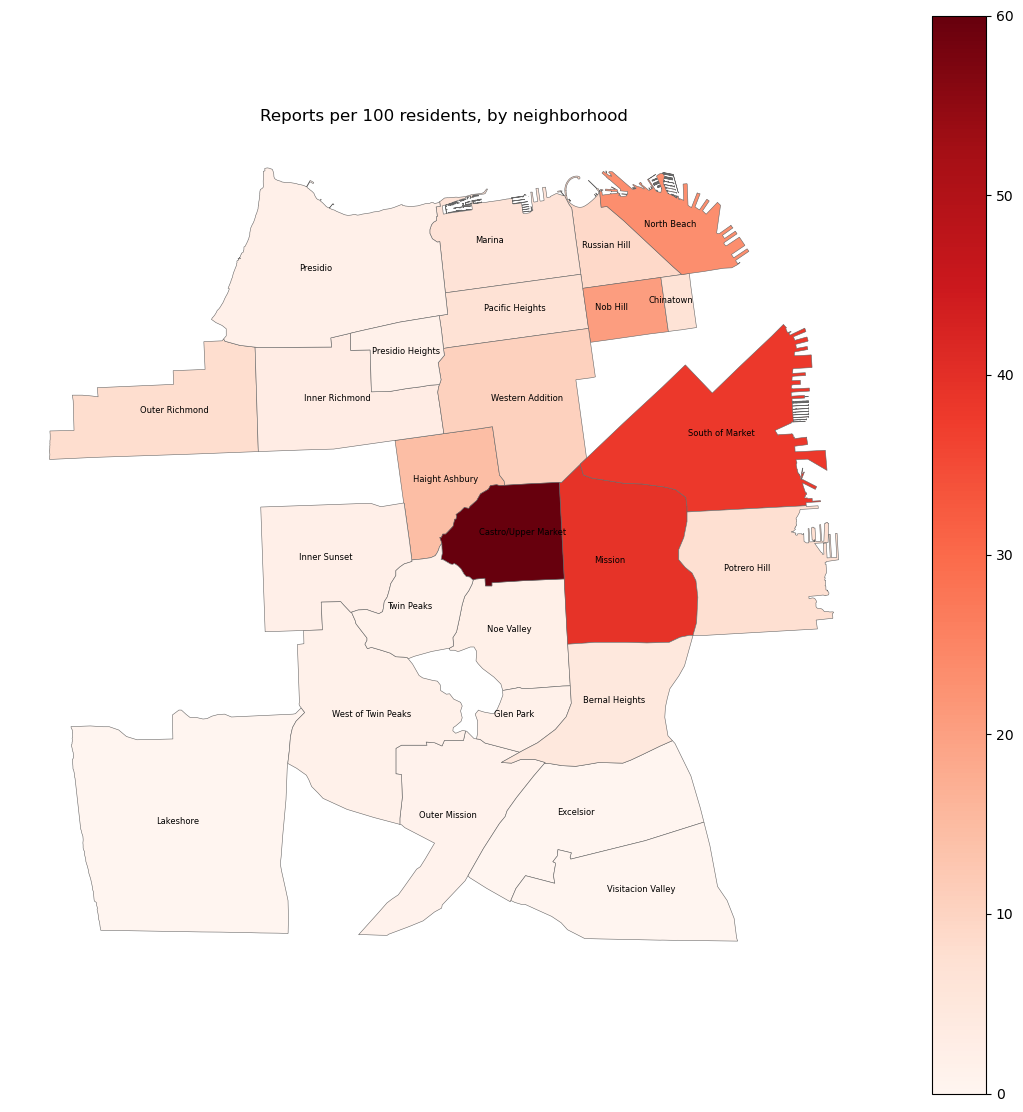

In [52]:
fig, ax = plt.subplots(1, figsize=(14, 14))
plt.xticks(rotation=90)
plt.title('Reports per 100 residents, by neighborhood')

map_and_data.plot(column="Reports Per 100", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")

bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=60))
bar_info._A = []
cbar = fig.colorbar(bar_info)
ax.axis("off")

for idx, row in map_and_data.iterrows():
    if row['geometry'].geom_type == 'Point':  # If it's a point geometry
        x, y = row['geometry'].x, row['geometry'].y
    else:
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y  # Get centroid for polygons
    
    ax.annotate(text=row['neighborhood'], xy=(x, y), xytext=(-22,0),
                textcoords="offset points", fontsize=6, color="black")

South of Market, Mission, and Central/Upper Market have a high number of reports, even after adjusting for population. 